# Table of Content

1) Import the Libraries

2) Get the Data

3) Cleaning the Data

4) Categorical Features Analysis

5) Numerical Features Analysis

6) Cunclosion

7) Feature Importance and Selection

8) Split the Train and Test datasets

9) Preprocessing the Data

10) Models and Evaluation

11) Comparing Model Scores

## Import the Libraries

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np 
import scipy.stats as stats
import pandas as pd
pd.pandas.set_option('display.max_columns',None)


from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict,learning_curve
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder , OneHotEncoder,FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2 ,f_classif
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## Get the Data

In [ ]:
heart=pd.read_csv('heart.csv')
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Cleaning the Data

In [128]:
heart_copy=heart.copy()
heart_copy.isnull().sum().sort_values(ascending=False)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Categorical Features Analysis

In [129]:
#Let's find the categorical featuers
cat_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes == object]
cat_features

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

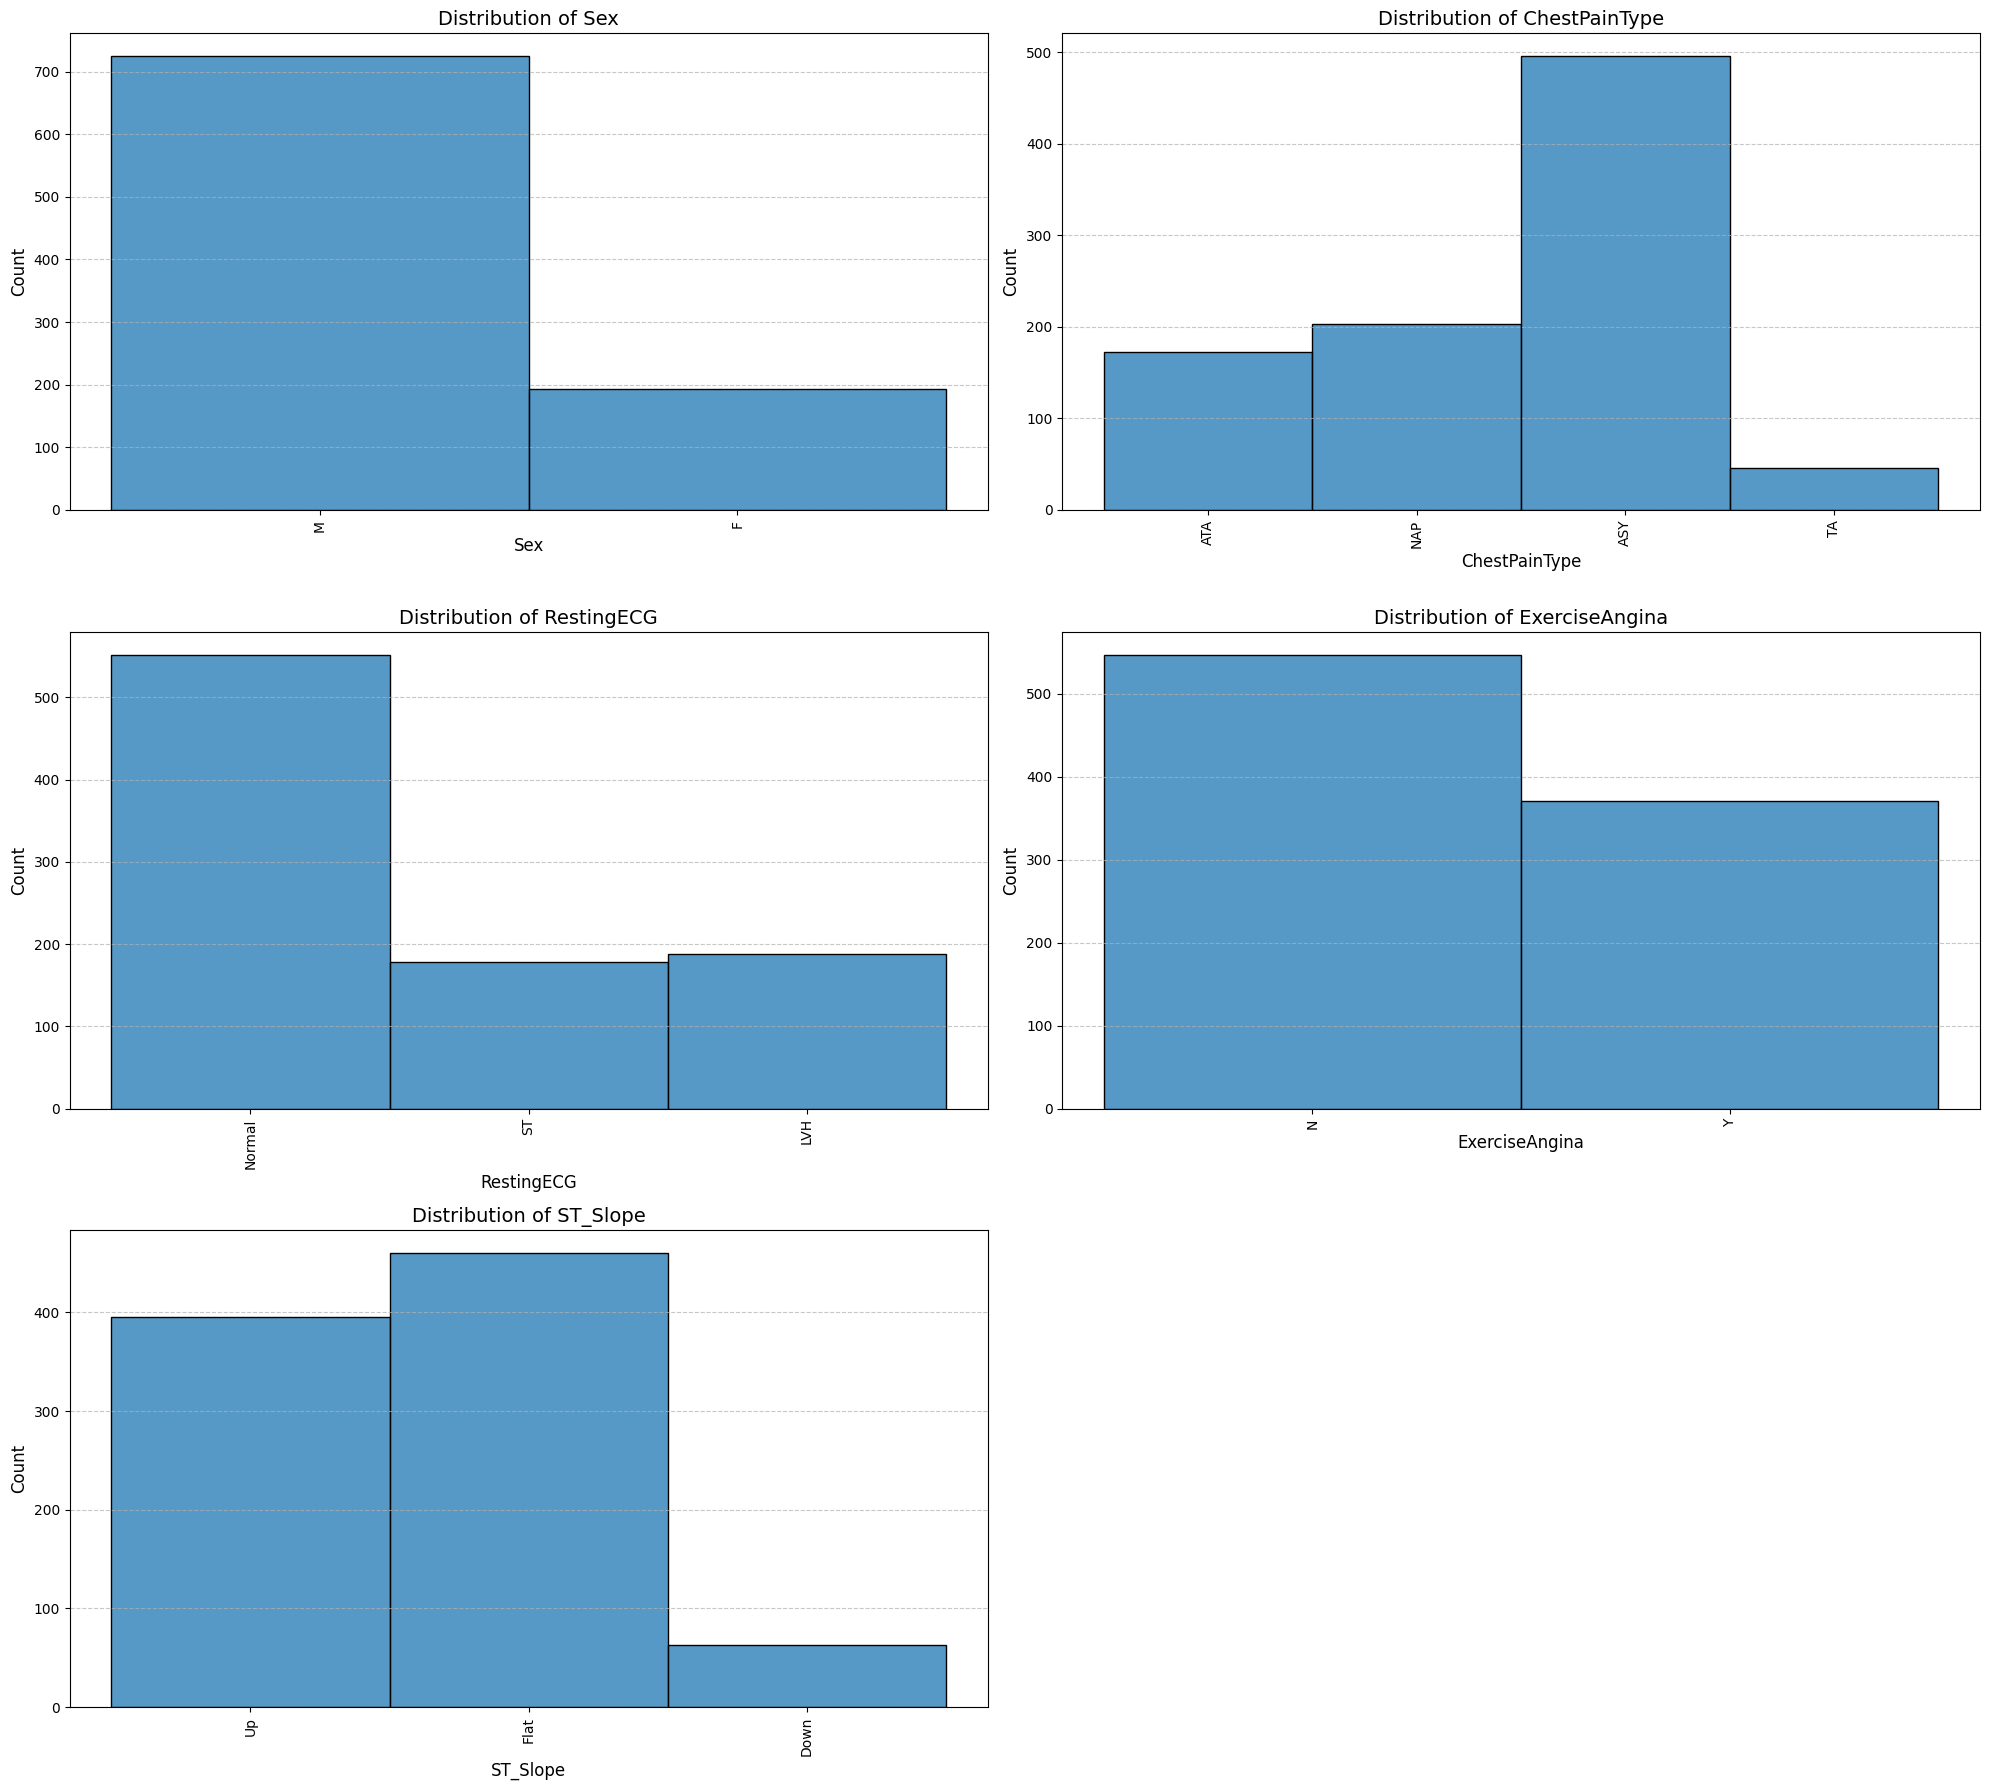

In [130]:
num_columns=2
num_rows=(len(cat_features)+1)//num_columns

fig,axes=plt.subplots(num_rows,num_columns,figsize=(20,num_rows * 6))
axes=axes.flatten()

for i , col in enumerate(cat_features):
    ax=axes[i]
    sns.histplot(data=heart_copy,x=col,ax=ax)
    
    ax.set_title(f'Distribution of {col}',fontsize=14)
    ax.set_xlabel(col,fontsize=12)
    ax.set_ylabel('Count',fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y',alpha=0.7,linestyle='--')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

### Heart Disease Ratio Comparison Across Categorical Features

- The distribution of **males** is significantly higher than **females** in the dataset.
- The most frequent **Chest Pain Type** among all individuals is **ASY** (asymptomatic), accounting for nearly half of the dataset.
- More than half of the **Resting ECG** measurements are classified as **Normal**.
- The majority of individuals exhibit a **Flat ST Slope** or **Upward ST Slope**, in contrast to the **Downward ST Slope**, which is less common.

Bivariate Analysis for Categorical Data:

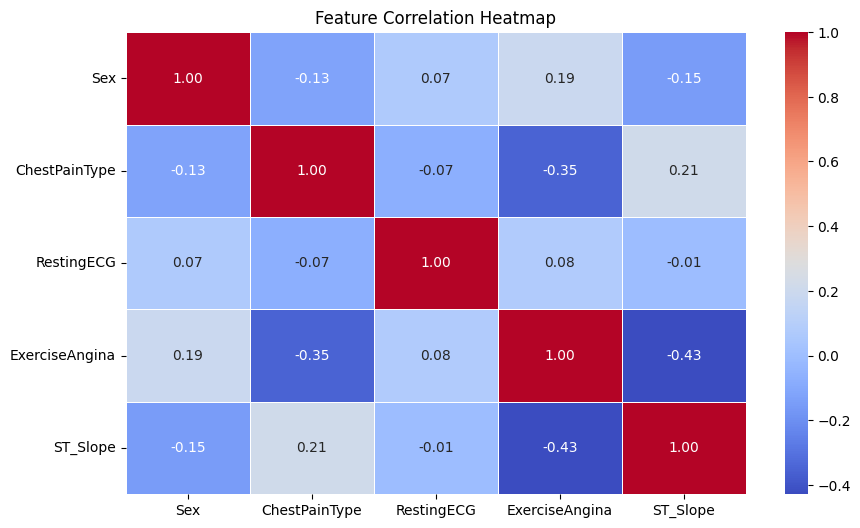

In [131]:
# For corr_matrix we need our categories to be encoded

encoder_ordinal=OrdinalEncoder()

df_new=pd.DataFrame(encoder_ordinal.fit_transform(heart_copy[cat_features]),columns=encoder_ordinal.get_feature_names_out(),index=heart_copy.index)

corr_matrix = df_new.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

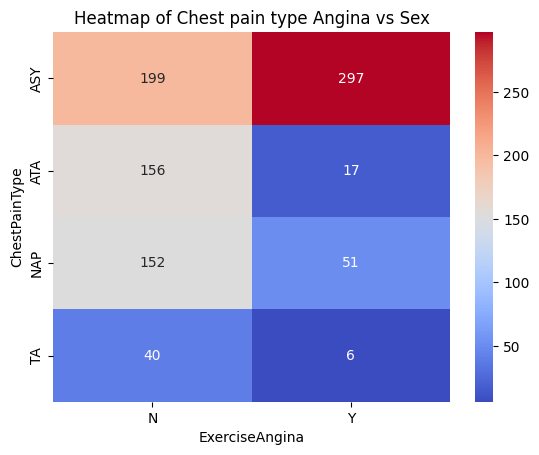

In [132]:
crosstab = pd.crosstab(heart_copy["ChestPainType"], heart_copy["ExerciseAngina"])
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Chest pain type Angina vs Sex")
plt.show()

- The **majority of individuals with ExerciseAngina** experience **ASY (Asymptomatic) Chest Pain Type**.
- This trend suggests that those who develop **exercise-induced angina** often do not exhibit traditional chest pain symptoms.
- The absence of typical chest pain in high-risk individuals may lead to **delayed diagnosis** of cardiovascular issues.
- This pattern could indicate that **silent ischemia** is more prevalent among individuals experiencing angina triggered by physical exertion.

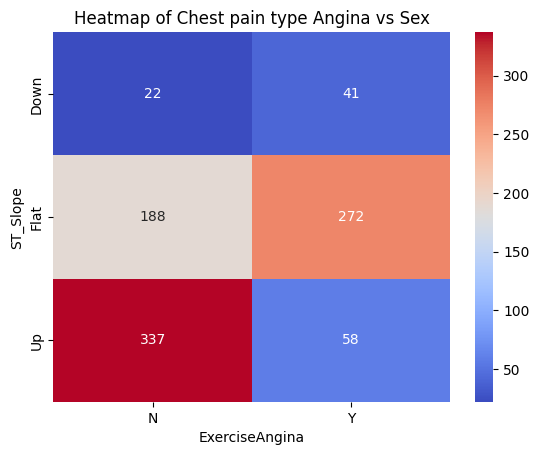

In [133]:
crosstab = pd.crosstab(heart_copy["ST_Slope"], heart_copy["ExerciseAngina"])
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Chest pain type Angina vs Sex")
plt.show()

- Individuals with a **flat ST slope** are more likely to experience **exercise-induced angina**, suggesting a potential link between heart stress and ST segment flattening.
- On the other hand, those with an **upward ST slope** tend to **not experience exercise-induced angina**, which may indicate better cardiovascular adaptability and response to physical exertion.
- This pattern suggests that the **shape of the ST segment during a stress test could be an important factor in diagnosing heart conditions**.

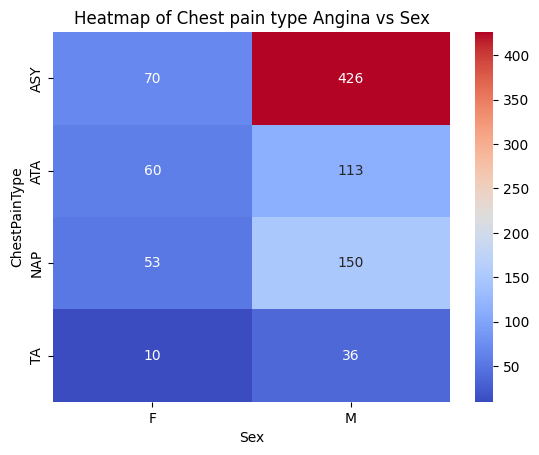

In [134]:
crosstab = pd.crosstab(heart_copy["ChestPainType"], heart_copy["Sex"])
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Chest pain type Angina vs Sex")
plt.show()

- The majority of **male individuals** in the dataset experience **asymptomatic (ASY) chest pain**.
- This trend suggests that **men may be more prone to silent cardiac issues**, where heart disease develops **without noticeable symptoms**.
- Since asymptomatic conditions are harder to detect, this could lead to **delayed diagnosis and treatment**, increasing the risk of severe cardiovascular events.
- The absence of typical chest pain symptoms may indicate that **other diagnostic markers, such as exercise response or ECG patterns, should be examined more closely for men**.

Comparing categorical features with target:

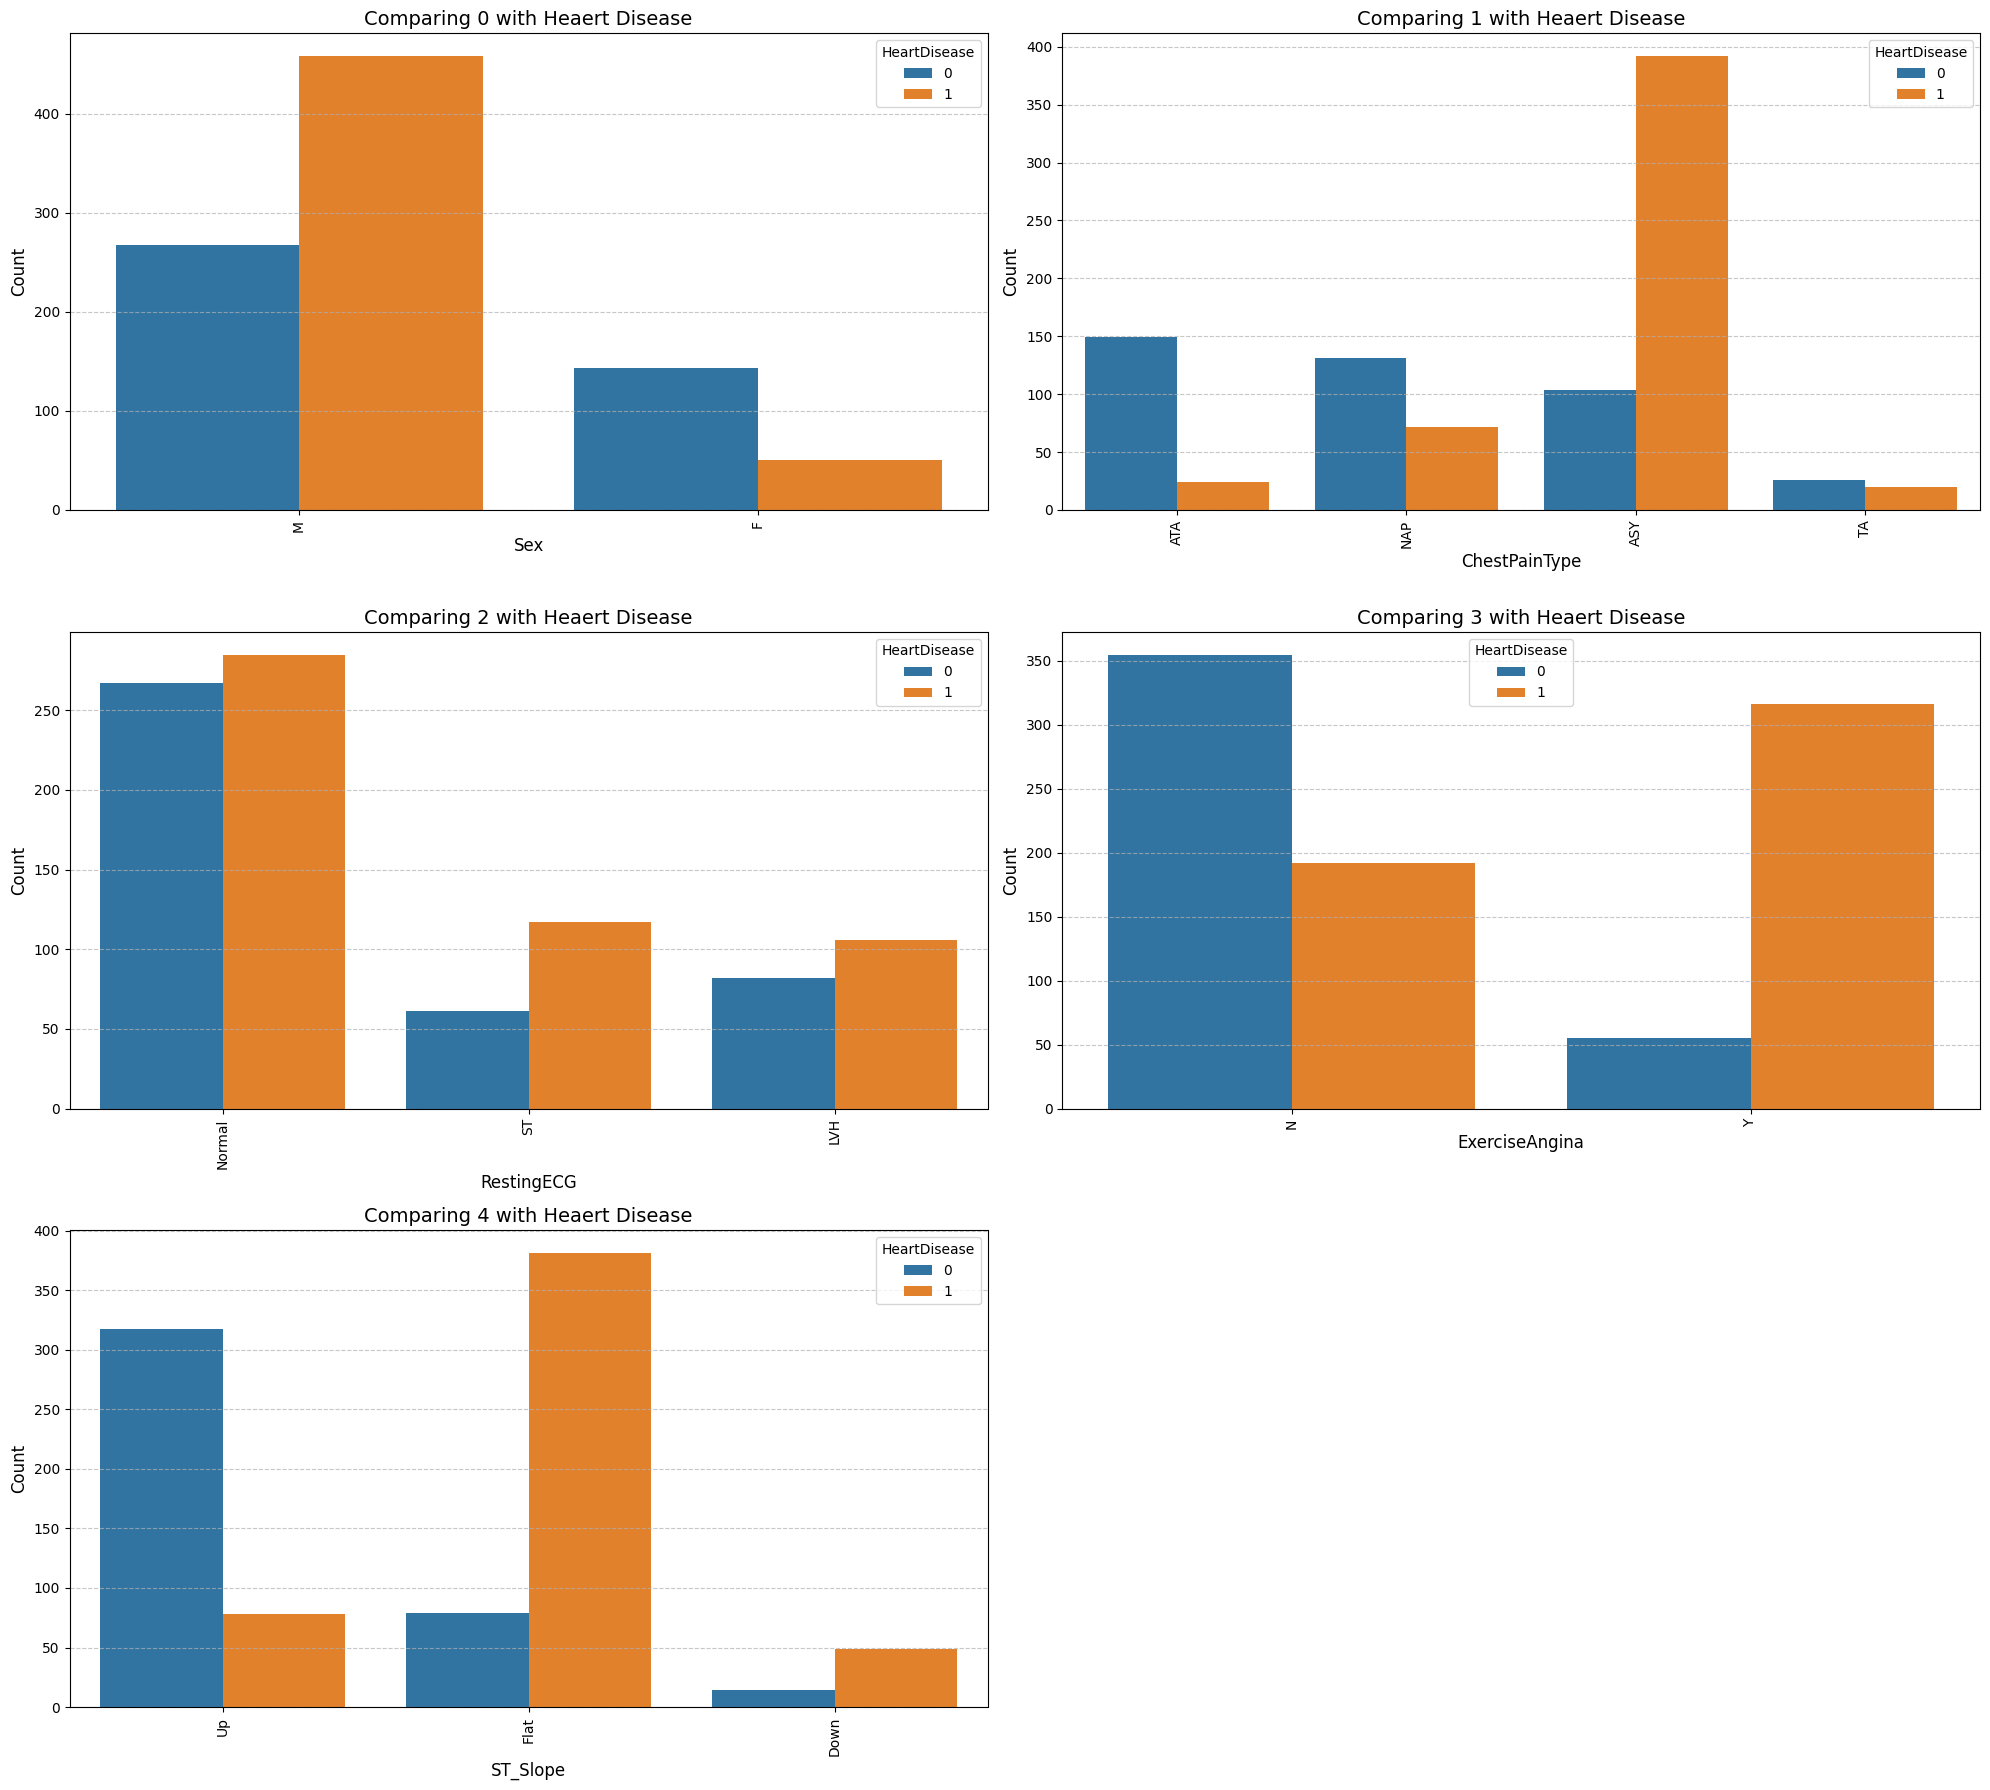

In [135]:
cat_df=pd.concat([heart_copy[cat_features],heart_copy['HeartDisease']],axis=1)

num_columns=2
num_rows=(len(cat_df.columns)+1)//num_columns

fig,axes=plt.subplots(num_rows,num_columns,figsize=(20,num_rows * 6))
axes=axes.flatten()

for i , col in enumerate(cat_df.drop(columns=['HeartDisease'])):
    ax=axes[i]
    ax=sns.countplot(ax=ax,data=cat_df,x=col,hue='HeartDisease')

    
    ax.set_title(f'Comparing {i} with Heaert Disease',fontsize=14)
    ax.set_xlabel(col,fontsize=12)
    ax.set_ylabel('Count',fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y',alpha=0.7,linestyle='--')
        
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

### Gender-Based Insights
- The occurrence of heart disease is notably higher in **males (63.17%)** compared to **females (25.90%)**, suggesting a potential gender-related risk factor.

### Chest Pain Type Analysis
- The most commonly associated **Chest Pain Type** among individuals with heart disease is **ASY (Asymptomatic) at 79.03%**, indicating that many affected individuals might not experience noticeable symptoms.
- **TA (Typical Angina) accounts for 43.47%**, followed by **NAP (Non-Anginal Pain) at 35.46%** and **ATA (Atypical Angina) at 13.87%**, suggesting varying pain symptoms among affected individuals.

### Resting ECG Correlation
- The majority of individuals with heart disease exhibit **ST (65.73%)**, indicating possible ST-segment elevation abnormalities.
- **LVH (Left Ventricular Hypertrophy) is observed in 56.38%**, a known factor associated with heart disease.
- **Normal ECG readings are present in 51.63%**, highlighting that some affected individuals may not show significant ECG abnormalities.

### Exercise-Induced Angina Impact
- A significant majority of individuals with heart disease experience **Exercise-Induced Angina (85.17%)**, reinforcing the connection between exertion and cardiovascular complications.
- **Non-angina cases account for 19.74%**, showing that some individuals may not exhibit angina symptoms despite having heart disease.

### ST Slope Interpretation
- **Flat ST Slope is predominant (82.82%)**, which is commonly associated with adverse cardiac conditions.
- **Downward ST Slope follows closely (77.77%)**, indicating potential ischemic heart disease risk.
- **Upward ST Slope is the least frequent (19.74%)**, suggesting it may be less indicative of severe cardiac issues.

## Numerical Features Analysis

In [136]:
#First we go for Discrete  numerical features
dis_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes!=object and heart_copy[feature].nunique()<10]
dis_features

['FastingBS', 'HeartDisease']

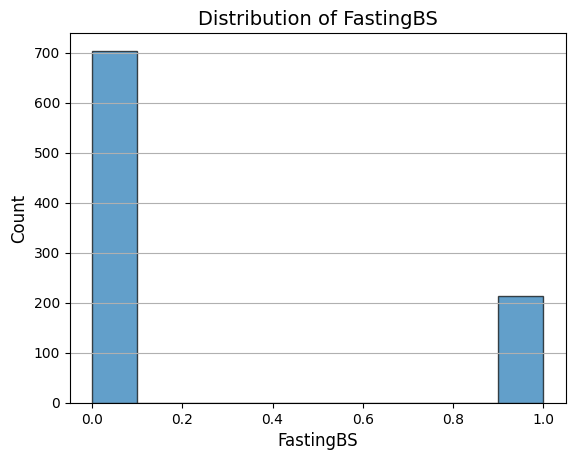

In [137]:
plt.figure()
plt.hist(heart_copy['FastingBS'],edgecolor='black',alpha=0.7)
plt.grid(axis='y')
plt.title('Distribution of FastingBS',fontsize=14)
plt.xlabel('FastingBS',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.show()

### Fasting Blood Sugar Distribution

- The majority of individuals in the dataset have a **Fasting Blood Sugar (FastingBS) value of 0**, accounting for more than **70%** of the data.
- This suggests that most individuals did not have elevated fasting blood sugar levels, which may indicate a lower prevalence of diabetes or prediabetes within the dataset.

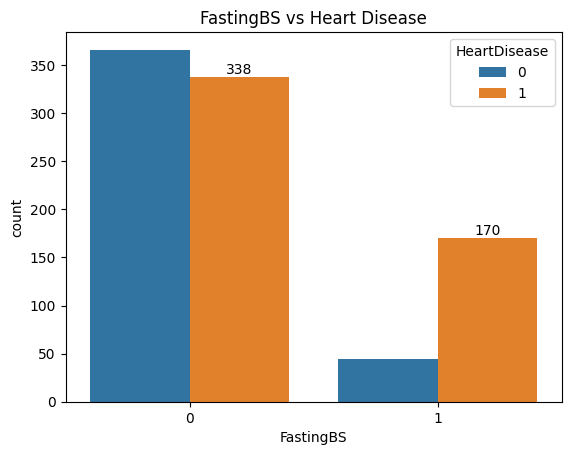

In [138]:
plt.figure(index)
ax=sns.countplot(data=heart_copy,x='FastingBS',hue='HeartDisease')
plt.title('FastingBS vs Heart Disease')
ax.bar_label(container)
plt.show()

### Relationship Between Fasting Blood Sugar and Heart Disease

### Observations
- Individuals with **FastingBS = 1** (indicating elevated fasting blood sugar levels) have a significantly higher prevalence of heart disease (**79.43%**).
- In contrast, individuals with **FastingBS = 0** exhibit a lower heart disease prevalence (**48.01%**).
- This suggests a strong correlation between elevated **fasting blood sugar** and the likelihood of heart disease, reinforcing the potential impact of diabetes or glucose metabolism on cardiovascular health.

### Heart Disease Ratio Comparison: Fasting Blood Sugar

### **Fasting Blood Sugar Levels**
- **1 (High Fasting Blood Sugar):** 79.43  
- **0 (Normal Fasting Blood Sugar):** 48.01  

*A higher fasting blood sugar level (≥ 126 mg/dL) is strongly associated with an increased likelihood of heart disease.*


In [139]:
#Know we go for continuous numerical features
conti_features=[feature for feature in heart_copy.columns if heart_copy[feature].dtypes!=object and feature not in dis_features]
conti_features

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

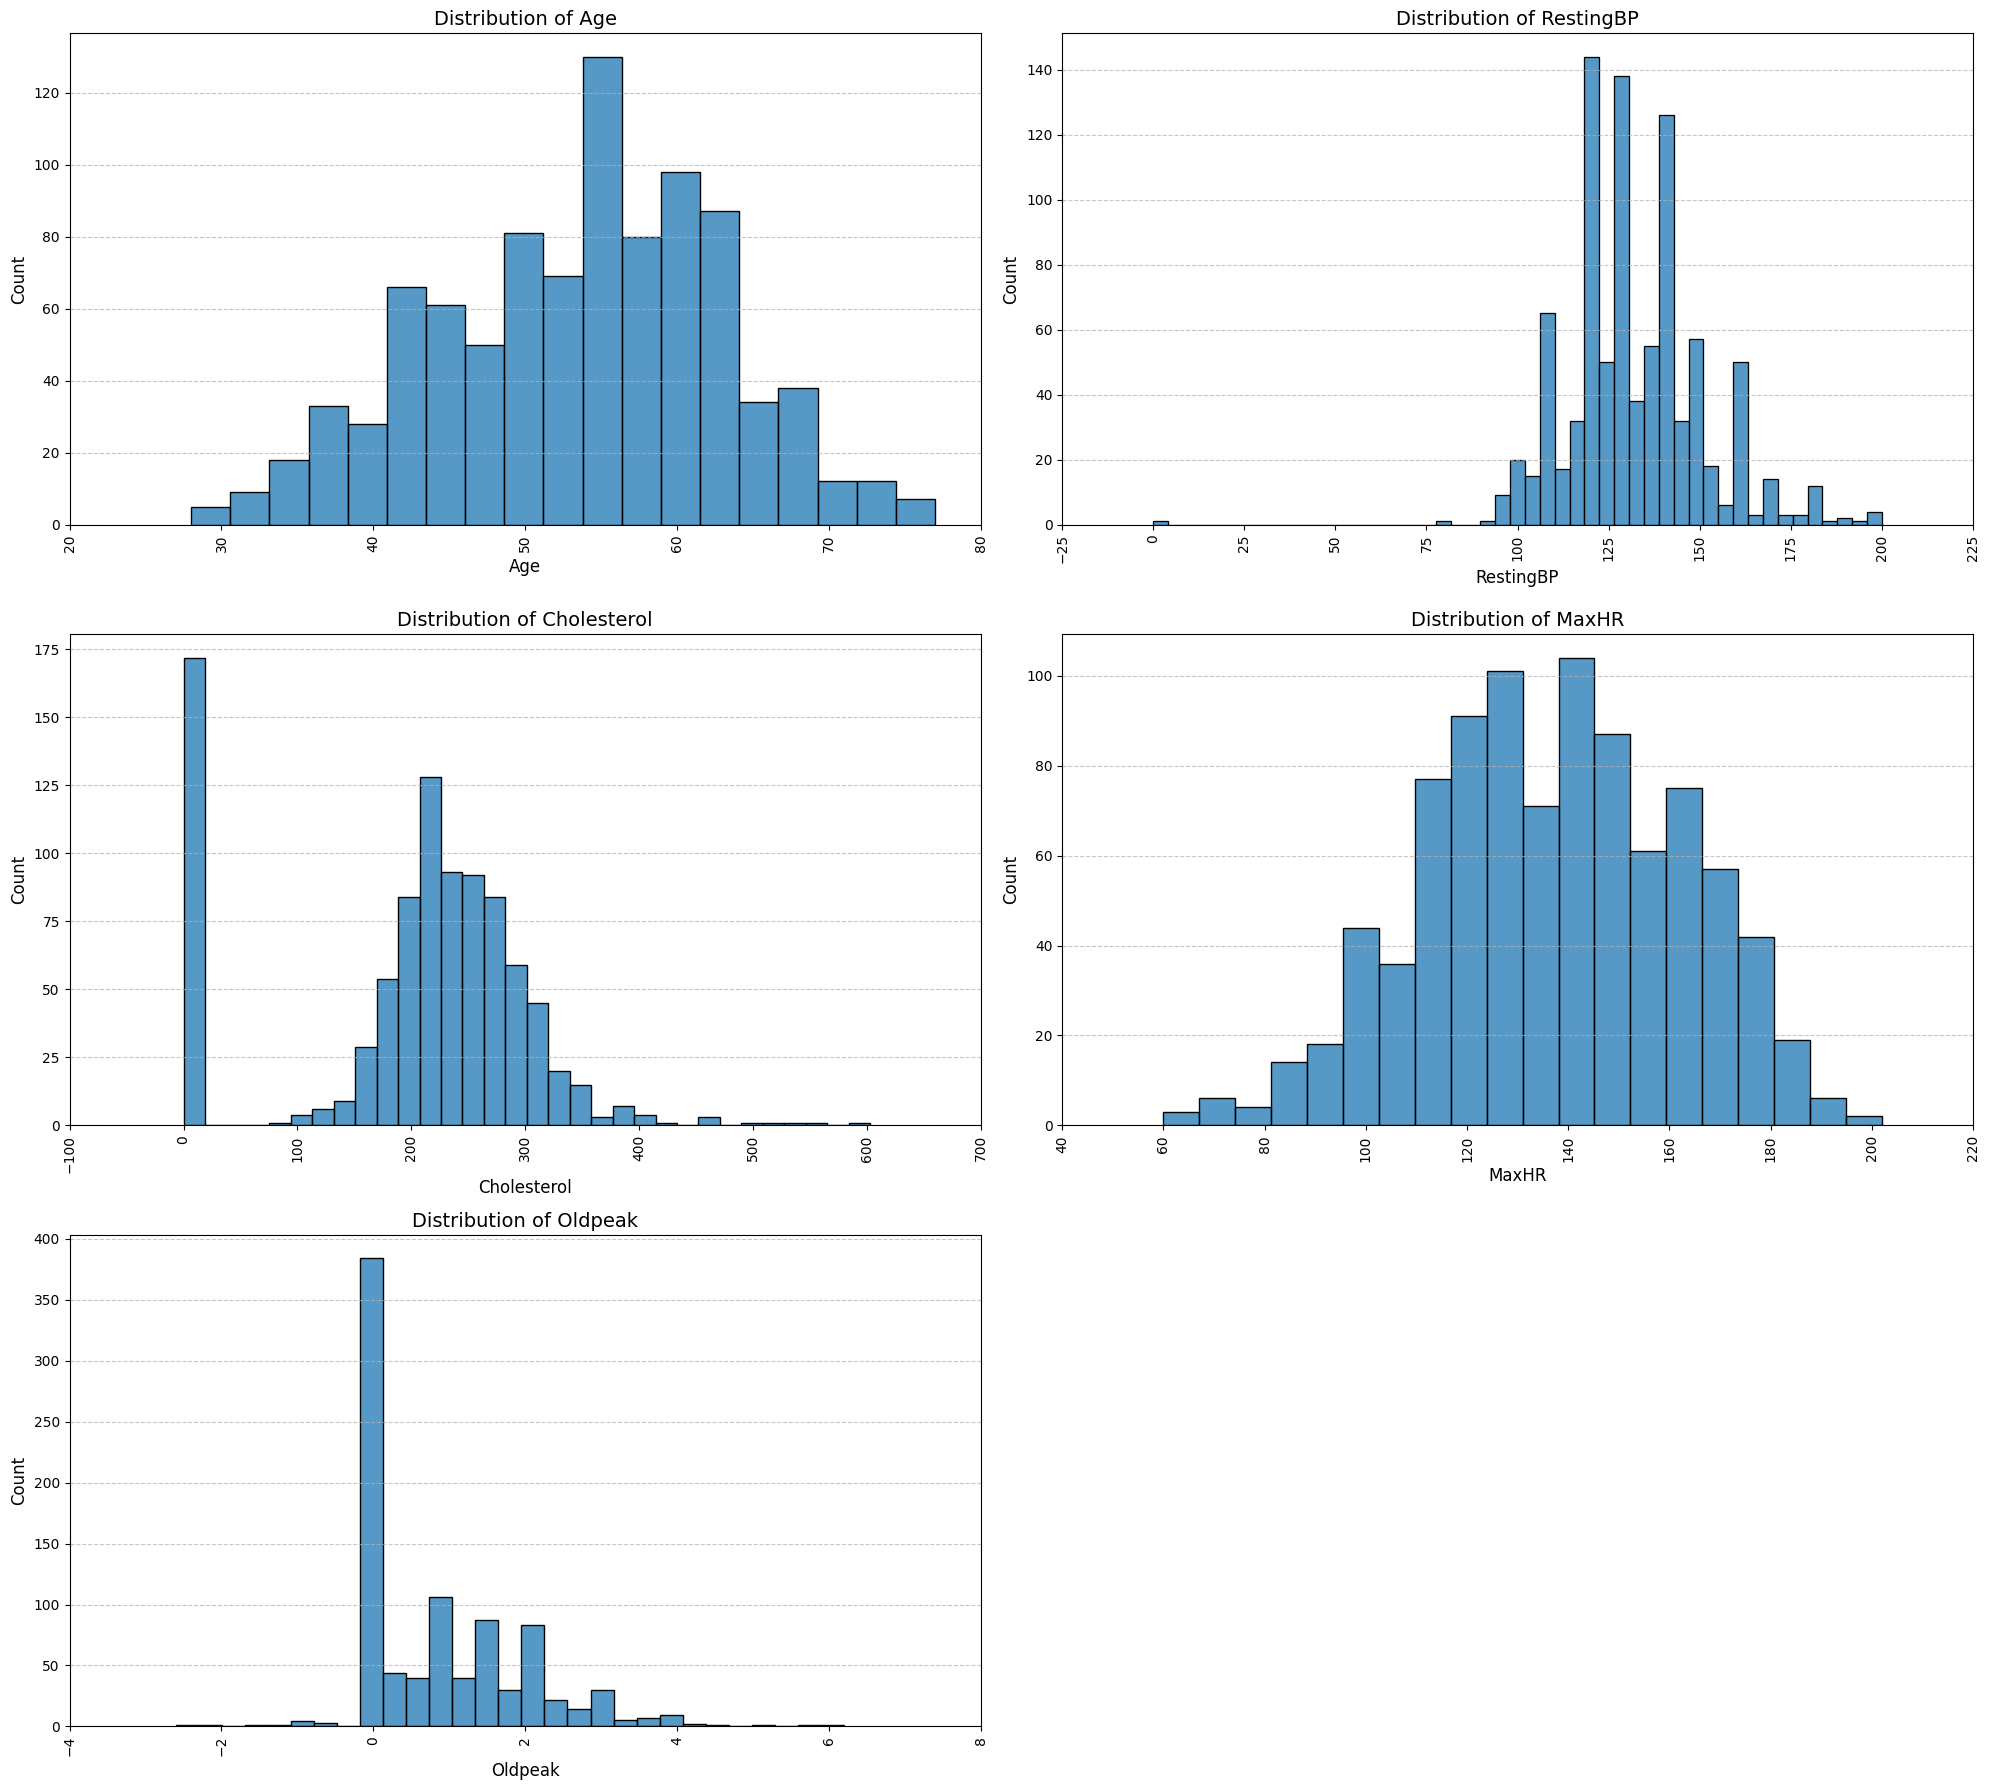

In [140]:
num_columns=2
num_rows=(len(conti_features)+1)//num_columns

fig,axes=plt.subplots(num_rows,num_columns,figsize=(20,num_rows * 6))
axes=axes.flatten()

for i , col in enumerate(conti_features):
    ax=axes[i]
    sns.histplot(data=heart_copy,x=col,ax=ax)
    
    ax.set_title(f'Distribution of {col}',fontsize=14)
    ax.set_xlabel(col,fontsize=12)
    ax.set_ylabel('Count',fontsize=12)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.grid(axis='y',alpha=0.7,linestyle='--')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

### Data Quality Assessment

### Age
- No invalid values detected for **Age** in the dataset.

### Resting Blood Pressure (RestingBP)
- **Zero values** for **RestingBP** are invalid.
- These values will be replaced with **nulls** to ensure data integrity.

### Cholesterol
- **Zero values** for **Cholesterol** are considered invalid.
- Since a large portion of the dataset contains **zero values**, a separate investigation is conducted to assess potential issues.See the separate analyisis further.

### Oldpeak
- No invalid values detected for **Oldpeak** at this stage of analysis.

In [141]:
# We convert invalid zeros for RestingBP then we drop it.
heart_copy['RestingBP']=heart_copy['RestingBP'].replace(0,np.nan)
heart_copy.dropna(subset=['RestingBP'],inplace=True)

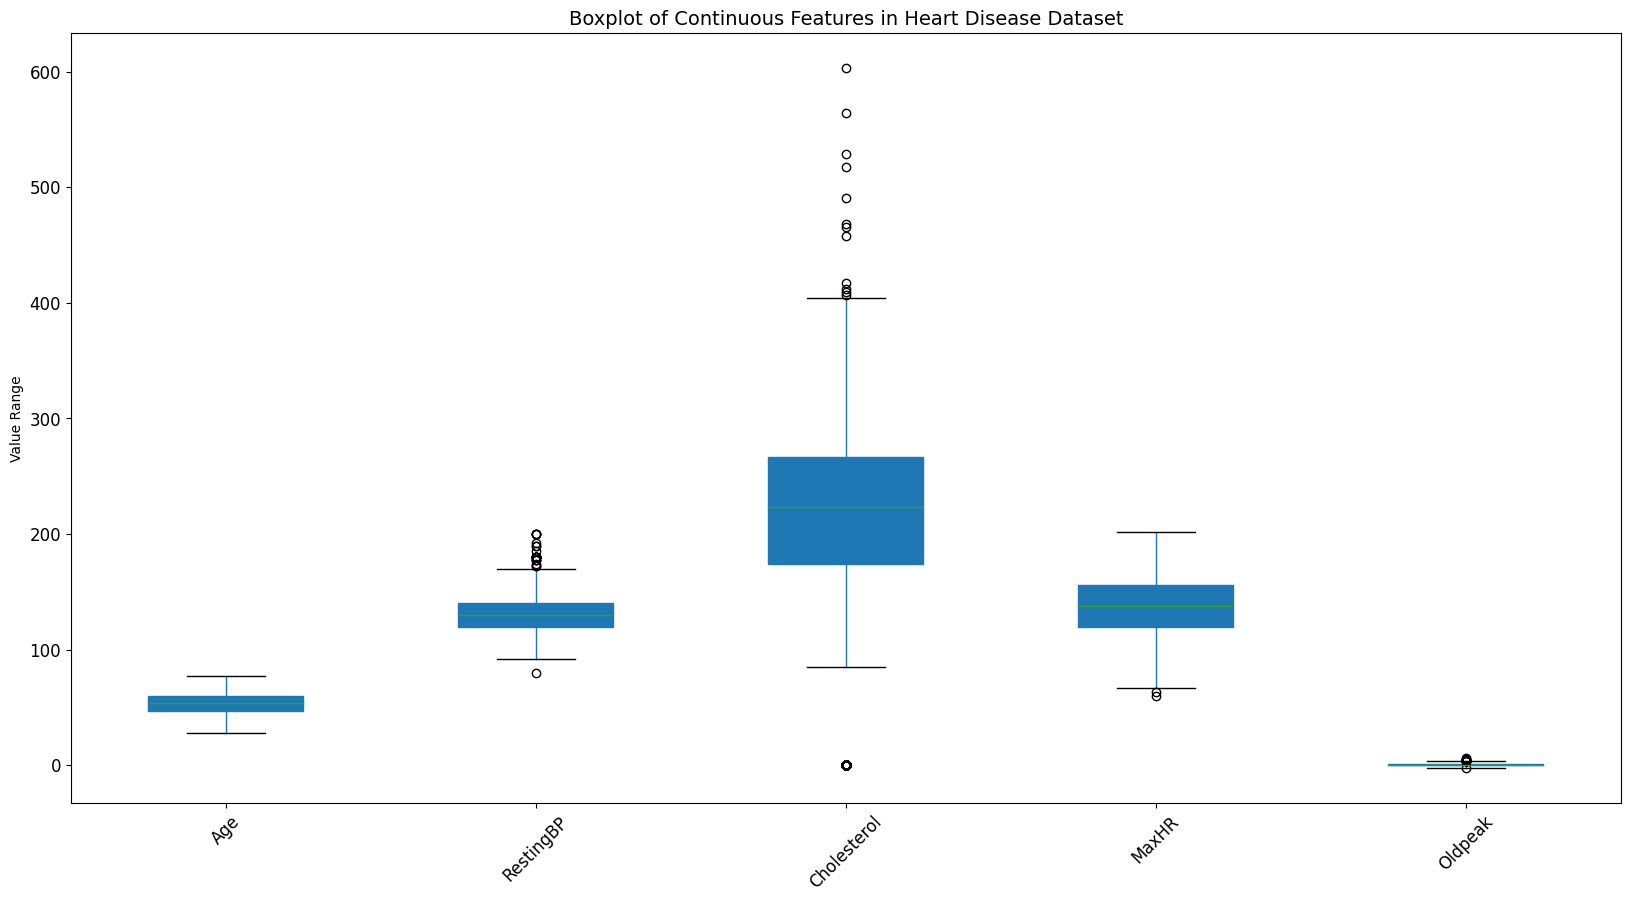

In [142]:

boxplot = heart_copy[conti_features].boxplot(figsize=(20,10), grid=False, fontsize=12, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow']  # Adjust as needed
for patch, color in zip(boxplot.artists, colors):
    patch.set_facecolor(color)

plt.title("Boxplot of Continuous Features in Heart Disease Dataset", fontsize=14)
plt.ylabel("Value Range")
plt.xticks(rotation=45)  
plt.show()

In [143]:
heart_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,917.0,53.509269,9.437636,28.0,47.0,54.0,60.0,77.0
RestingBP,917.0,132.540894,17.999749,80.0,120.0,130.0,140.0,200.0
Cholesterol,917.0,199.016358,109.246330,0.0,174.0,223.0,267.0,603.0
FastingBS,917.0,0.233370,0.423206,0.0,0.0,0.0,0.0,1.0
MaxHR,917.0,136.789531,25.467129,60.0,120.0,138.0,156.0,202.0
Oldpeak,917.0,0.886696,1.066960,-2.6,0.0,0.6,1.5,6.2
HeartDisease,917.0,0.552890,0.497466,0.0,0.0,1.0,1.0,1.0


## Outlier Analysis and Treatment

### Observations
- The dataset contains a **considerable number of outliers** across various features.
- These outliers may significantly impact the overall analysis and predictive modeling.
- Identifying and handling these extreme values is crucial for improving data quality and model performance.

Checking Cholesterol invalid Zeros:

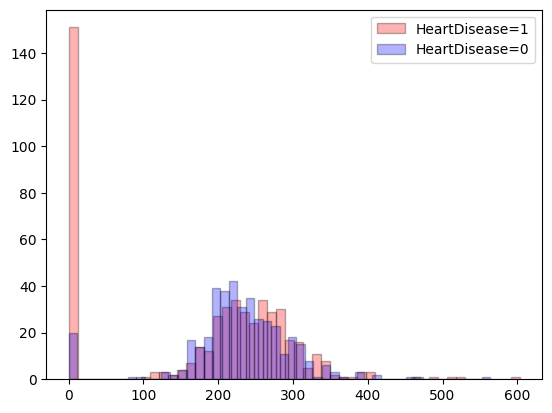

In [144]:
#Checking Cholesterol invalid zeros so we can check it's impact on  Heart Disease

heart_disease_0 = heart_copy[heart_copy['HeartDisease'] == 0]
heart_disease_1 = heart_copy[heart_copy['HeartDisease'] == 1]

plt.hist(heart_disease_1['Cholesterol'], color='red', label='HeartDisease=1',bins=50,alpha=0.3,edgecolor='black')
plt.hist(heart_disease_0['Cholesterol'], color='blue', label='HeartDisease=0', bins=50,alpha=0.3,edgecolor='black')
plt.legend()
plt.show()

### Observations
- A significant number of **invalid zero values** for cholesterol are observed in individuals with **heart disease**, compared to those without.
- This discrepancy suggests that many of these **zero values** might actually represent **high cholesterol levels** rather than truly missing or absent data.
- The pattern indicates a potential **data entry issue** or incorrect recording of cholesterol values for individuals at higher risk of heart disease.
- Further validation and imputation strategies may be necessary to ensure data integrity and derive accurate insights.

Encoding the dataset to impute cholesterole using knnimputer:

In [145]:

encoder = OrdinalEncoder()

features = ['Sex', 'ExerciseAngina', 'ChestPainType', 'RestingECG', 'ST_Slope']
cat_encoded = encoder.fit_transform(heart_copy[features])
cat_encoded = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(), index=heart_copy.index)  # Convert sparse matrix to dense
df_encoded = pd.concat([heart_copy.drop(columns=features), cat_encoded], axis=1)  # Ensure proper merging

In [146]:

knn_imputer = KNNImputer(n_neighbors=5)

df_encoded['Cholesterol'] = df_encoded['Cholesterol'].replace(0,np.nan)

df_encoded['Cholesterol']=knn_imputer.fit_transform(df_encoded)

heart_copy['Cholesterol']=df_encoded['Cholesterol']

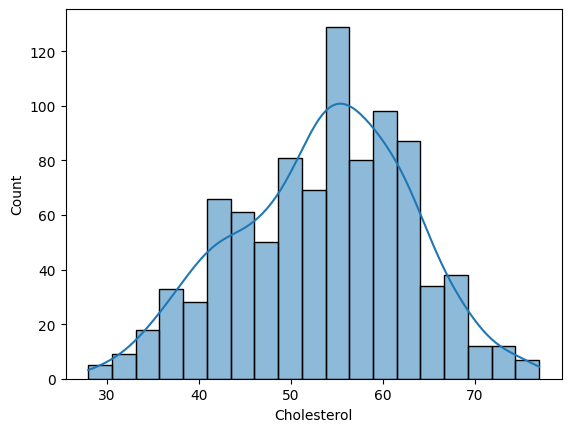

In [147]:
#Let's plot the cholesetor again and see the changes
plt.figure()
sns.histplot(heart_copy['Cholesterol'],kde=True)
plt.show()

Bivariate Analysis for numerical Data:

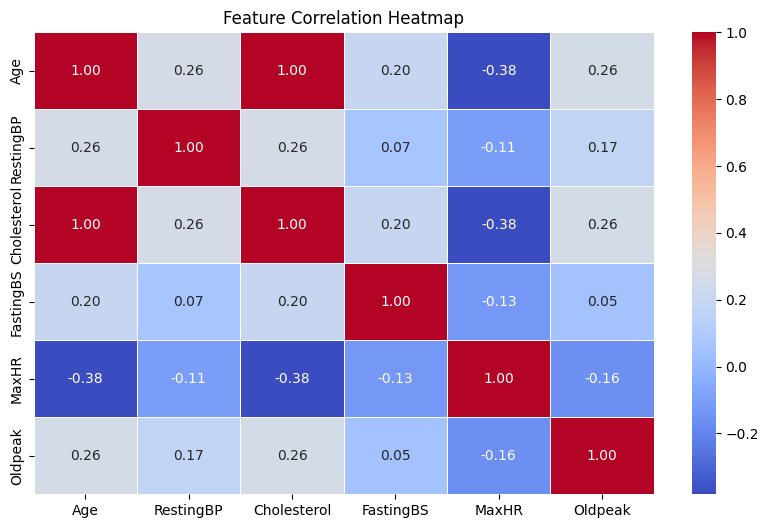

In [148]:
corr_matrix = heart_copy.select_dtypes(exclude=object).drop(columns='HeartDisease').corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

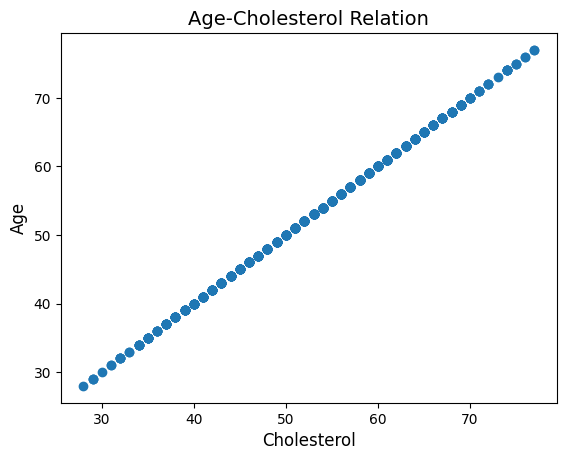

In [149]:
plt.figure()
plt.scatter(x=heart_copy['Cholesterol'],y=heart_copy['Age'])
plt.title('Age-Cholesterol Relation',fontsize=14)
plt.xlabel('Cholesterol',fontsize=12)
plt.ylabel('Age',fontsize=12)
plt.show()

- The **Cholesterol** and **Age** features exhibit a **perfect correlation (1.0)**.
- This suggests a highly linear relationship where **cholesterol values increase proportionally with age**.
- Such a strong correlation could indicate **data redundancy** or potential issues with data recording.
- Further validation is needed to ensure this correlation is **accurate** and not due to an underlying data artifact.
- If confirmed, this relationship could be **important for predictive modeling**, influencing feature selection in machine learning.

In [150]:
for i in conti_features:
    print(f"{i}:{df_encoded[i].skew()}")

Age:-0.19532159788386802
RestingBP:0.6071947160162691
Cholesterol:-0.19532159788386802
MaxHR:-0.14245852926814553
Oldpeak:1.0245446342890443


- The **Oldpeak** feature exhibits **moderate skewness**, which may affect the performance of machine learning models.
- Skewed data can introduce bias, impact model assumptions, and reduce predictive accuracy.

## Feature Importance and Selection

In [151]:
df_encoded['HR_ExerciseImpact'] = df_encoded['MaxHR'] / (df_encoded['Oldpeak'] + 5)

In [152]:
cat_encoded_features=[i for i in df_encoded.columns if df_encoded[i].nunique()<10]

Chi2 Test:

In [153]:
X = df_encoded[cat_encoded_features]  
y = df_encoded['HeartDisease']  

chi2_selector = SelectKBest(score_func=chi2, k='all')  
X_selected = chi2_selector.fit_transform(X, y)

# Retrieve feature importance scores
scores = chi2_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'Chi2 Score': scores})
feature_scores = feature_scores.sort_values(by='Chi2 Score', ascending=False)

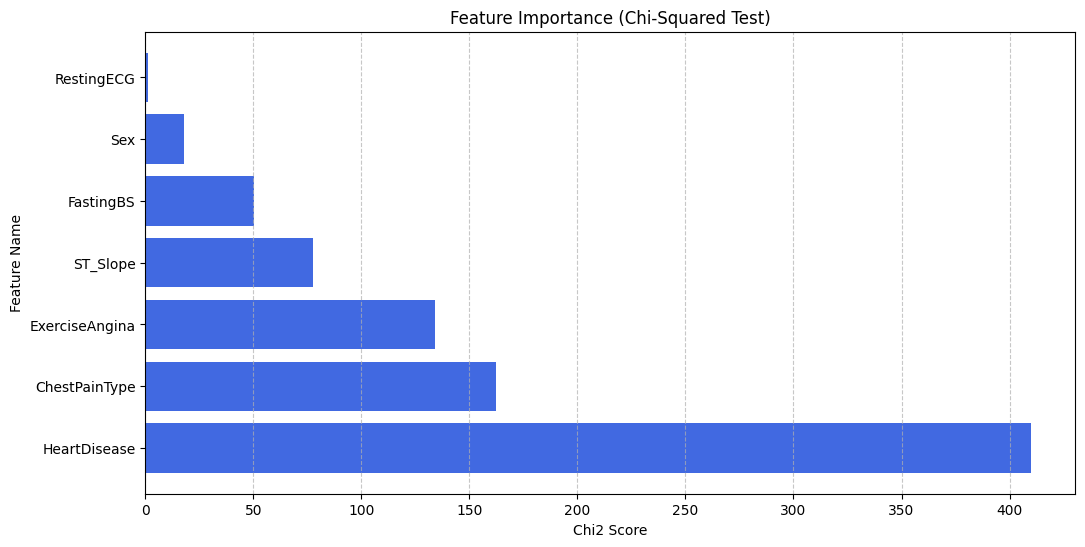

In [154]:
plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'], feature_scores['Chi2 Score'], color='royalblue')
plt.xlabel('Chi2 Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance (Chi-Squared Test)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Chi2 Test Rsult: Feature Importance
- The **Chi-Square test** results indicate that **RestingECG** and **Sex** have the **least feature importance** in relation to heart disease prediction.
- This suggests that these features **may not contribute significantly** to distinguishing between individuals with and without heart disease.
- While **RestingECG** is an important diagnostic tool, its statistical impact in this dataset appears minimal.
- The **Sex** feature also shows limited influence, implying that heart disease risk factors might be **more closely tied to other clinical or lifestyle attributes**.
- Further analysis could involve **feature selection techniques** to determine if these features should be excluded from predictive modeling.

In [155]:
num_encoded_features=[i for i in df_encoded.columns if df_encoded[i].nunique()>10]

Anova Test:

In [156]:

X = df_encoded[num_encoded_features]  
y = heart_copy['HeartDisease']  

anova_selector = SelectKBest(score_func=f_classif, k='all')  # Select all for evaluation
X_selected = anova_selector.fit_transform(X, y)

scores = anova_selector.scores_
feature_scores = pd.DataFrame({'Feature': X.columns, 'ANOVA Score': scores})


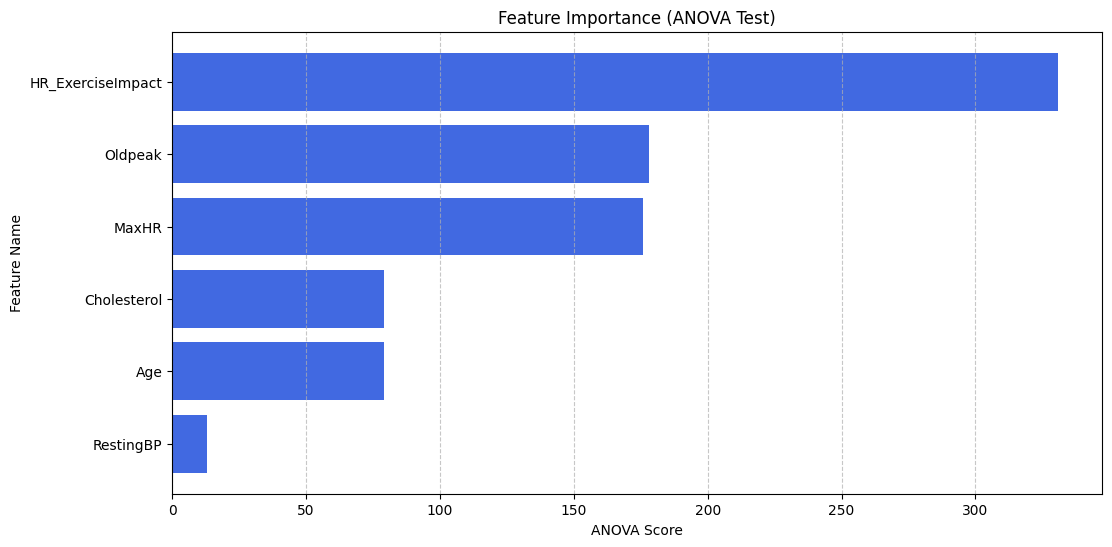

In [157]:
feature_scores=feature_scores.sort_values(by='ANOVA Score',ascending=True)
plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'], feature_scores['ANOVA Score'], color='royalblue')
plt.xlabel('ANOVA Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance (ANOVA Test)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### ANOVA Test Results: Feature Importance Analysis

### Observations
- The **ANOVA test** indicates that **RestingBP (Resting Blood Pressure)** has the **least importance** in this dataset.
- In contrast, **Oldpeak** and **MaxHR (Maximum Heart Rate)** exhibit a **strong relationship**, suggesting their significant influence on heart disease prediction.
- The high correlation between **Oldpeak and MaxHR** may indicate that exercise-induced changes in heart rate and ST depression play a crucial role in cardiovascular health.

Permutation feature Importance test:

In [158]:
X=df_encoded.drop(columns=['HeartDisease'])
y=df_encoded['HeartDisease']
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X, y)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rnd_clf.feature_importances_})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


perm_importance = permutation_importance(rnd_clf, X, y, scoring='f1')

perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

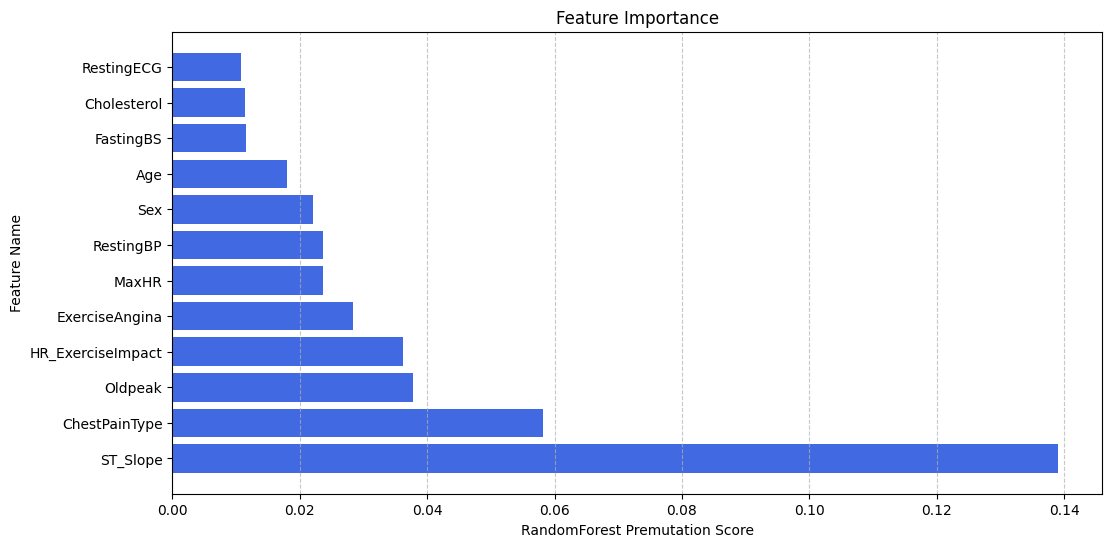

In [159]:
plt.figure(figsize=(12, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], color='royalblue')
plt.xlabel('RandomForest Premutation Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

- After the test we are sure wich our new feature is usefull, so we add it do the main dataset.

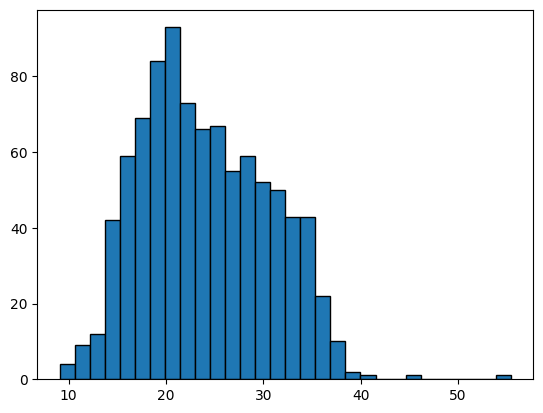

In [160]:
heart_copy['HR_ExerciseImpact'] = heart_copy['MaxHR'] / (heart_copy['Oldpeak'] + 5)

plt.figure()
plt.hist(heart_copy['HR_ExerciseImpact'],bins=30,edgecolor='black')
plt.show()

### Feature Selection:
- Acording to test results it's better to drop **RestingECG** and **FastingBS**.

In [161]:
heart_copy.drop(columns=['RestingECG','FastingBS'],inplace=True)

## Cunclosion

### **Key Insights**
1. **Demographic Distribution**
   - The dataset contains **significantly more male individuals than females**.
   - The most frequent **Chest Pain Type** is **Asymptomatic (ASY)**, affecting nearly half of the dataset.

2. **Chest Pain & Exercise-Induced Angina**
   - **Individuals with Exercise-Induced Angina** predominantly experience **Asymptomatic Chest Pain**.
   - This suggests that **silent ischemia** could be prevalent among individuals experiencing exertion-triggered angina, leading to delayed diagnosis.

3. **ST Slope & Angina Patterns**
   - Those with a **flat ST slope** are more likely to suffer from **exercise-induced angina**.
   - Individuals with an **upward ST slope** tend to **not experience exercise-induced angina**, indicating better cardiovascular adaptability.

4. **Gender-Based Disease Patterns**
   - **Men show a higher occurrence of heart disease (63.17%) compared to women (25.90%)**.
   - Since asymptomatic heart disease is more common in men, alternative **diagnostic markers** like ECG and exercise response should be examined closely.

5. **Resting ECG Correlation**
   - Most individuals with heart disease have **ST segment abnormalities (65.73%)**.
   - **LVH (Left Ventricular Hypertrophy)** is common among affected individuals (56.38%).
   - Surprisingly, **some individuals with heart disease exhibit normal ECG readings (51.63%)**.

6. **Feature Importance Analysis**
   - **RestingECG, Sex, and RestingBP** have **minimal predictive importance** according to Chi-Square and ANOVA tests.
   - In contrast, **Oldpeak and MaxHR demonstrate strong relationships with heart disease**, making them crucial for predictive modeling.

7. **Fasting Blood Sugar & Heart Disease**
   - Elevated **Fasting Blood Sugar (FastingBS = 1) is strongly associated with heart disease (79.43%)**.
   - Individuals with **FastingBS = 0** exhibit a lower prevalence of heart disease (48.01%).

8. **Data Quality & Outliers**
   - Several features contain **outliers**, which may affect model predictions.
   - **Zero values in Cholesterol and RestingBP appear invalid**, potentially requiring imputation or further investigation.

## Split the Train and Test datasets

In [162]:
X,y=heart_copy.drop(columns=['HeartDisease']),heart_copy['HeartDisease'].copy()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=heart_copy['ST_Slope'])


## Preprocessing the Data

In [163]:
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


cat_ordinal=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder()
)



numeric_features = ['HR_ExerciseImpact','Age', 'MaxHR', 'Oldpeak', 'Cholesterol']
categorical_features = [ 'ChestPainType','ST_Slope']
ordinal_cat=['Sex','ExerciseAngina',]
all=numeric_features+categorical_features


preprocessor = ColumnTransformer([
    ('cat_one_hot_trans', categorical_transformer, categorical_features),  
    ('num_trans', num_transformer, numeric_features),
    ('ordinal_trans',cat_ordinal, ordinal_cat)
], remainder='drop')

preprocessor_pipe=make_pipeline(
    preprocessor,
    KNNImputer(n_neighbors=5)
)

X_transformed = preprocessor_pipe.fit_transform(heart_copy)


In [164]:
X_transformed = pd.DataFrame(X_transformed,columns=preprocessor_pipe.get_feature_names_out(),index=heart_copy.index)
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 0 to 917
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cat_one_hot_trans__ChestPainType_ASY  917 non-null    float64
 1   cat_one_hot_trans__ChestPainType_ATA  917 non-null    float64
 2   cat_one_hot_trans__ChestPainType_NAP  917 non-null    float64
 3   cat_one_hot_trans__ChestPainType_TA   917 non-null    float64
 4   cat_one_hot_trans__ST_Slope_Down      917 non-null    float64
 5   cat_one_hot_trans__ST_Slope_Flat      917 non-null    float64
 6   cat_one_hot_trans__ST_Slope_Up        917 non-null    float64
 7   num_trans__HR_ExerciseImpact          917 non-null    float64
 8   num_trans__Age                        917 non-null    float64
 9   num_trans__MaxHR                      917 non-null    float64
 10  num_trans__Oldpeak                    917 non-null    float64
 11  num_trans__Cholesterol  

## Models and Evaluation

In [165]:
#SGDClassifier:
sgd_clf=make_pipeline(preprocessor_pipe,SGDClassifier(random_state=42))

#sgd_clf tuning
param_grid = {
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(sgd_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {np.round(grid_search.best_score_ * 100 , 2)}")

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters: {'sgdclassifier__alpha': 0.01, 'sgdclassifier__max_iter': 1000, 'sgdclassifier__penalty': 'elasticnet'}
Best score: 86.76


In [166]:
sgd_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_one_hot_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['ChestPainType',
                                                                    'ST_Slope']),
                                                                  ('num_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy=...
                                                                                    StandardScaler())]),
                                                                   ['HR_ExerciseImpact',
                                                                    'Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol']),
                                                                  ('ordinal_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinalencoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['Sex',
                                                                    'ExerciseAngina'])])),
                                 ('knnimputer', KNNImputer())])),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.01, penalty='elasticnet',
                               random_state=42))])

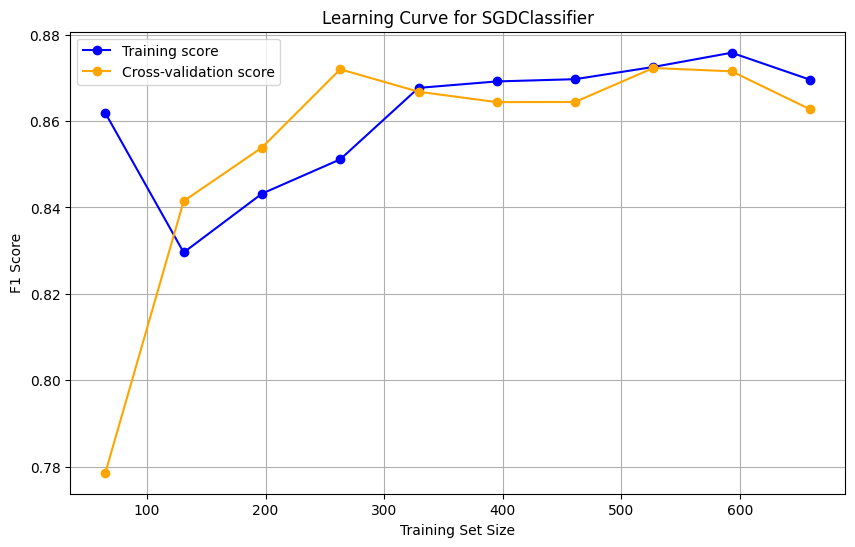

In [167]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    sgd_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for SGDClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [168]:
#Creating knn_clf
knn_clf=make_pipeline(
    preprocessor_pipe,
    KNeighborsClassifier()
)

#Tune the knn_model hyperparameters

param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 21),  
    'kneighborsclassifier__weights': ['uniform', 'distance'],  
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski']  
}




grid_search = GridSearchCV(knn_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", np.round(grid_search.best_score_ * 100 ,2))

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best parameters: {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 15, 'kneighborsclassifier__weights': 'uniform'}
Best accuracy: 87.37


In [169]:
# Update the Knn_clf model with the best parameters
knn_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_one_hot_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['ChestPainType',
                                                                    'ST_Slope']),
                                                                  ('num_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy=...
                                                                                    StandardScaler())]),
                                                                   ['HR_ExerciseImpact',
                                                                    'Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol']),
                                                                  ('ordinal_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinalencoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['Sex',
                                                                    'ExerciseAngina'])])),
                                 ('knnimputer', KNNImputer())])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=15))])

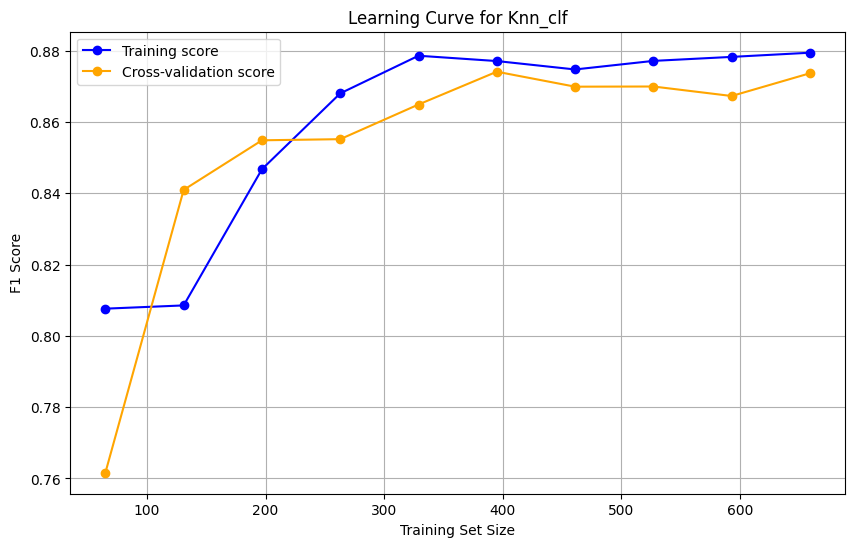

In [170]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    knn_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Knn_clf')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [171]:
#Creating the GuassianNB_clf model
GaussianNB_clf=make_pipeline(
    preprocessor_pipe,
    GaussianNB()
)

#Tune the GuassianNB_clf hyperparameters
param_grid = {'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

grid_search = GridSearchCV(GaussianNB_clf, param_grid, cv=10, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", np.round(grid_search.best_score_ * 100,2))

Best parameters: {'gaussiannb__var_smoothing': 1e-09}
Best accuracy: 84.94


In [172]:
# Update the GaussianNB_clf model with the best parameters
GaussianNB_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_one_hot_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['ChestPainType',
                                                                    'ST_Slope']),
                                                                  ('num_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['HR_ExerciseImpact',
                                                                    'Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol']),
                                                                  ('ordinal_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinalencoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['Sex',
                                                                    'ExerciseAngina'])])),
                                 ('knnimputer', KNNImputer())])),
                ('gaussiannb', GaussianNB())])

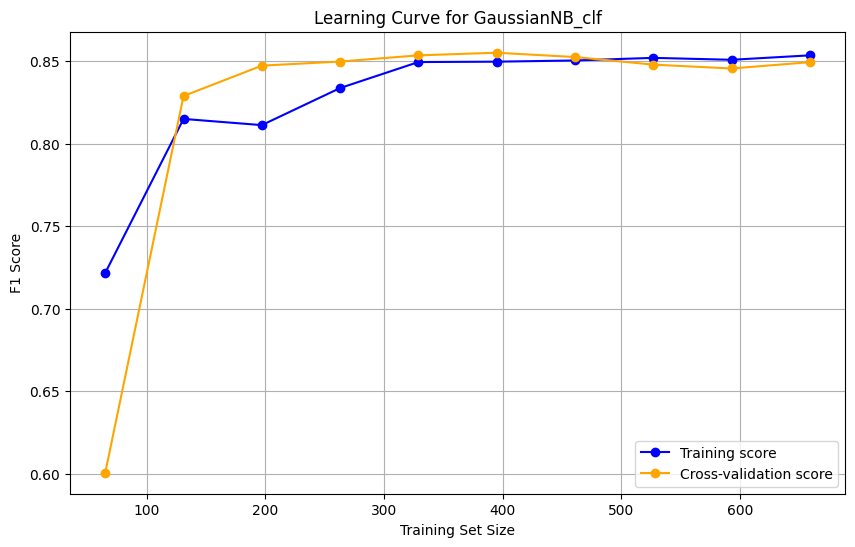

In [173]:
#Creating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    GaussianNB_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for GaussianNB_clf')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [174]:
#Creating SVC model
svc_clf=make_pipeline(
    preprocessor_pipe,
    SVC(random_state=42)
)

#Tuning SVC classifier hyperparameters

param_grid = {
    'svc__C': [0.1, 1, 10],  
    'svc__kernel': ['poly', 'rbf','linear'],  
    'svc__gamma': ['scale', 'auto'],  
    'svc__degree': [2, 3]  
}

grid_search = GridSearchCV(svc_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)  

print("Best Parameters:", grid_search.best_params_)
print("Best f1:", np.round(grid_search.best_score_ * 100 , 2))


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best Parameters: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best f1: 87.06


In [175]:
# Update the SVC model with the best parameters
svc_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_one_hot_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['ChestPainType',
                                                                    'ST_Slope']),
                                                                  ('num_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy=...)),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   ['HR_ExerciseImpact',
                                                                    'Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol']),
                                                                  ('ordinal_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinalencoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['Sex',
                                                                    'ExerciseAngina'])])),
                                 ('knnimputer', KNNImputer())])),
                ('svc', SVC(C=0.1, degree=2, kernel='poly', random_state=42))])

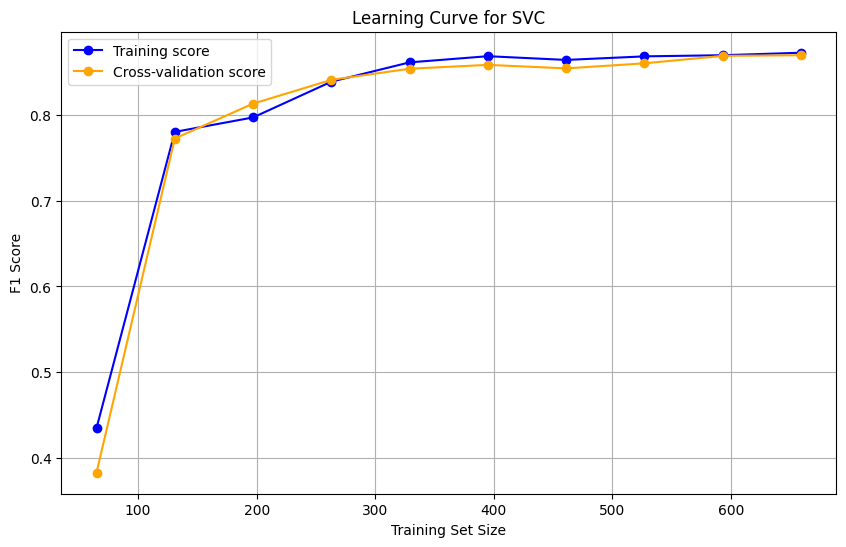

In [176]:
#Creating learning curve for SVC model
train_sizes, train_scores, test_scores = learning_curve(
    svc_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for SVC')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [177]:
#Creating DecisionTreeClassifier
dt_clf=make_pipeline(
    preprocessor_pipe,
    DecisionTreeClassifier(random_state=42)
)

# Hyperparameter tuning for DecisionTreeClassifier
param_grid = {
    'decisiontreeclassifier__max_depth': [None,5, 10, 20],
    'decisiontreeclassifier__min_samples_split': [5, 10,20],
    'decisiontreeclassifier__min_samples_leaf': [ 2, 4,8],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(dt_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {np.round(grid_search.best_score_ * 100,2)}")

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 10}
Best score: 84.65


In [178]:
#Updating the DecisionTreeClassifier with best parameters
dt_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_one_hot_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['ChestPainType',
                                                                    'ST_Slope']),
                                                                  ('num_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy=...
                                                                    'Oldpeak',
                                                                    'Cholesterol']),
                                                                  ('ordinal_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinalencoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['Sex',
                                                                    'ExerciseAngina'])])),
                                 ('knnimputer', KNNImputer())])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=2,
                                        min_samples_split=10,
                                        random_state=42))])

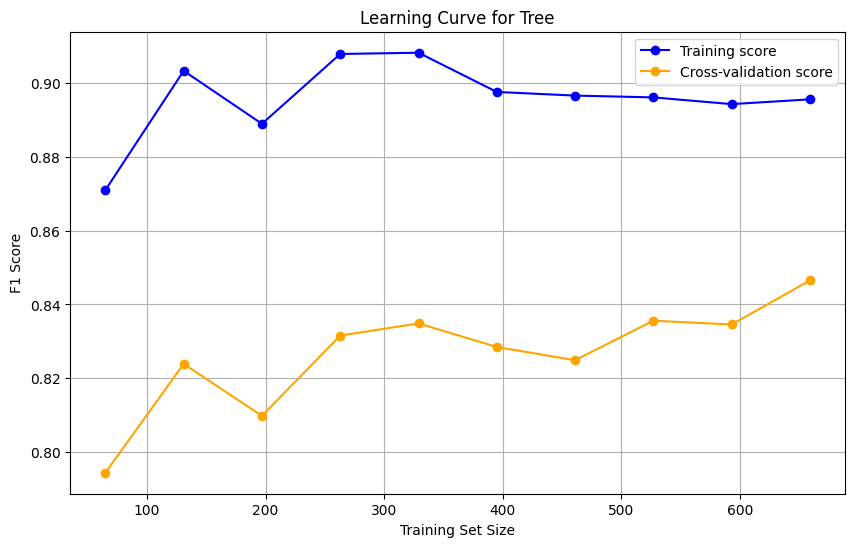

In [179]:
#Creating the learning curve for DecisionTreeClassifier
train_sizes, train_scores, test_scores = learning_curve(
    dt_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for Tree')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [180]:
#Create RandomForestClassifier model
rnd_clf=make_pipeline(
    preprocessor_pipe,
    RandomForestClassifier(random_state=42)
)

#Tune the rnd_clf hyperparameters
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(rnd_clf, param_grid, cv=10, scoring='f1', n_jobs=-1,verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {np.round(grid_search.best_score_ * 100,2)}")

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 100}
Best score: 87.2


In [181]:
#Updating the rnd_clf with best parameters
rnd_clf.set_params(**grid_search.best_params_)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('cat_one_hot_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['ChestPainType',
                                                                    'ST_Slope']),
                                                                  ('num_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy=...
                                                                    'Age',
                                                                    'MaxHR',
                                                                    'Oldpeak',
                                                                    'Cholesterol']),
                                                                  ('ordinal_trans',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('ordinalencoder',
                                                                                    OrdinalEncoder())]),
                                                                   ['Sex',
                                                                    'ExerciseAngina'])])),
                                 ('knnimputer', KNNImputer())])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

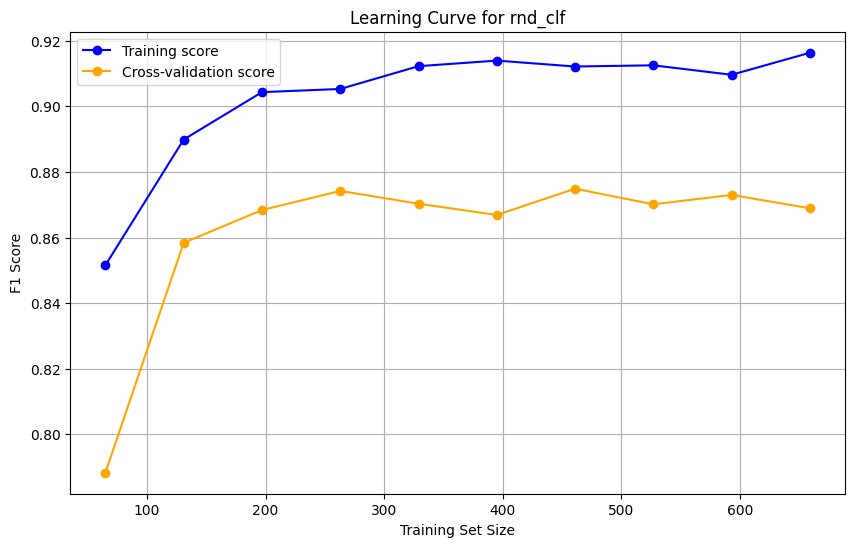

In [182]:
#Creating the learning curve for rnd_clf
train_sizes, train_scores, test_scores = learning_curve(
    rnd_clf, X_train, y_train, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange', marker='o')

plt.title('Learning Curve for rnd_clf')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

## Comparing Model Scores

In [183]:
sgd_predicts=cross_val_predict(sgd_clf,X_train,y_train,cv=10)
knn_predicts=cross_val_predict(knn_clf,X_train,y_train,cv=10)
GaussianNB_predicts=cross_val_predict(GaussianNB_clf,X_train,y_train,cv=10)
dt_predicts=cross_val_predict(dt_clf,X_train,y_train,cv=10)
rnd_predicts=cross_val_predict(rnd_clf,X_train,y_train,cv=10)

#sgd_scores
sgd_clf_f1=f1_score(y_train,sgd_predicts)
sgd_clf_precision=precision_score(y_train,sgd_predicts)
sgd_clf_recall=recall_score(y_train,sgd_predicts)

#knn_scores
knn_clf_f1=f1_score(y_train,knn_predicts)
knn_clf_precision=precision_score(y_train,knn_predicts)
knn_clf_recall=recall_score(y_train,knn_predicts)

#GuassianNB_scores
GaussianNB_clf_f1=f1_score(y_train,GaussianNB_predicts)
GaussianNB_clf_precision=precision_score(y_train,GaussianNB_predicts)
GaussianNB_clf_recall=recall_score(y_train,GaussianNB_predicts)

#df_scores
dt_clf_f1=f1_score(y_train,dt_predicts)
dt_clf_precision=precision_score(y_train,dt_predicts)
dt_clf_recall=recall_score(y_train,dt_predicts)

#rnd_scores
rnd_clf_f1=f1_score(y_train,rnd_predicts)
rnd_clf_precision=precision_score(y_train,rnd_predicts)
rnd_clf_recall=recall_score(y_train,rnd_predicts)



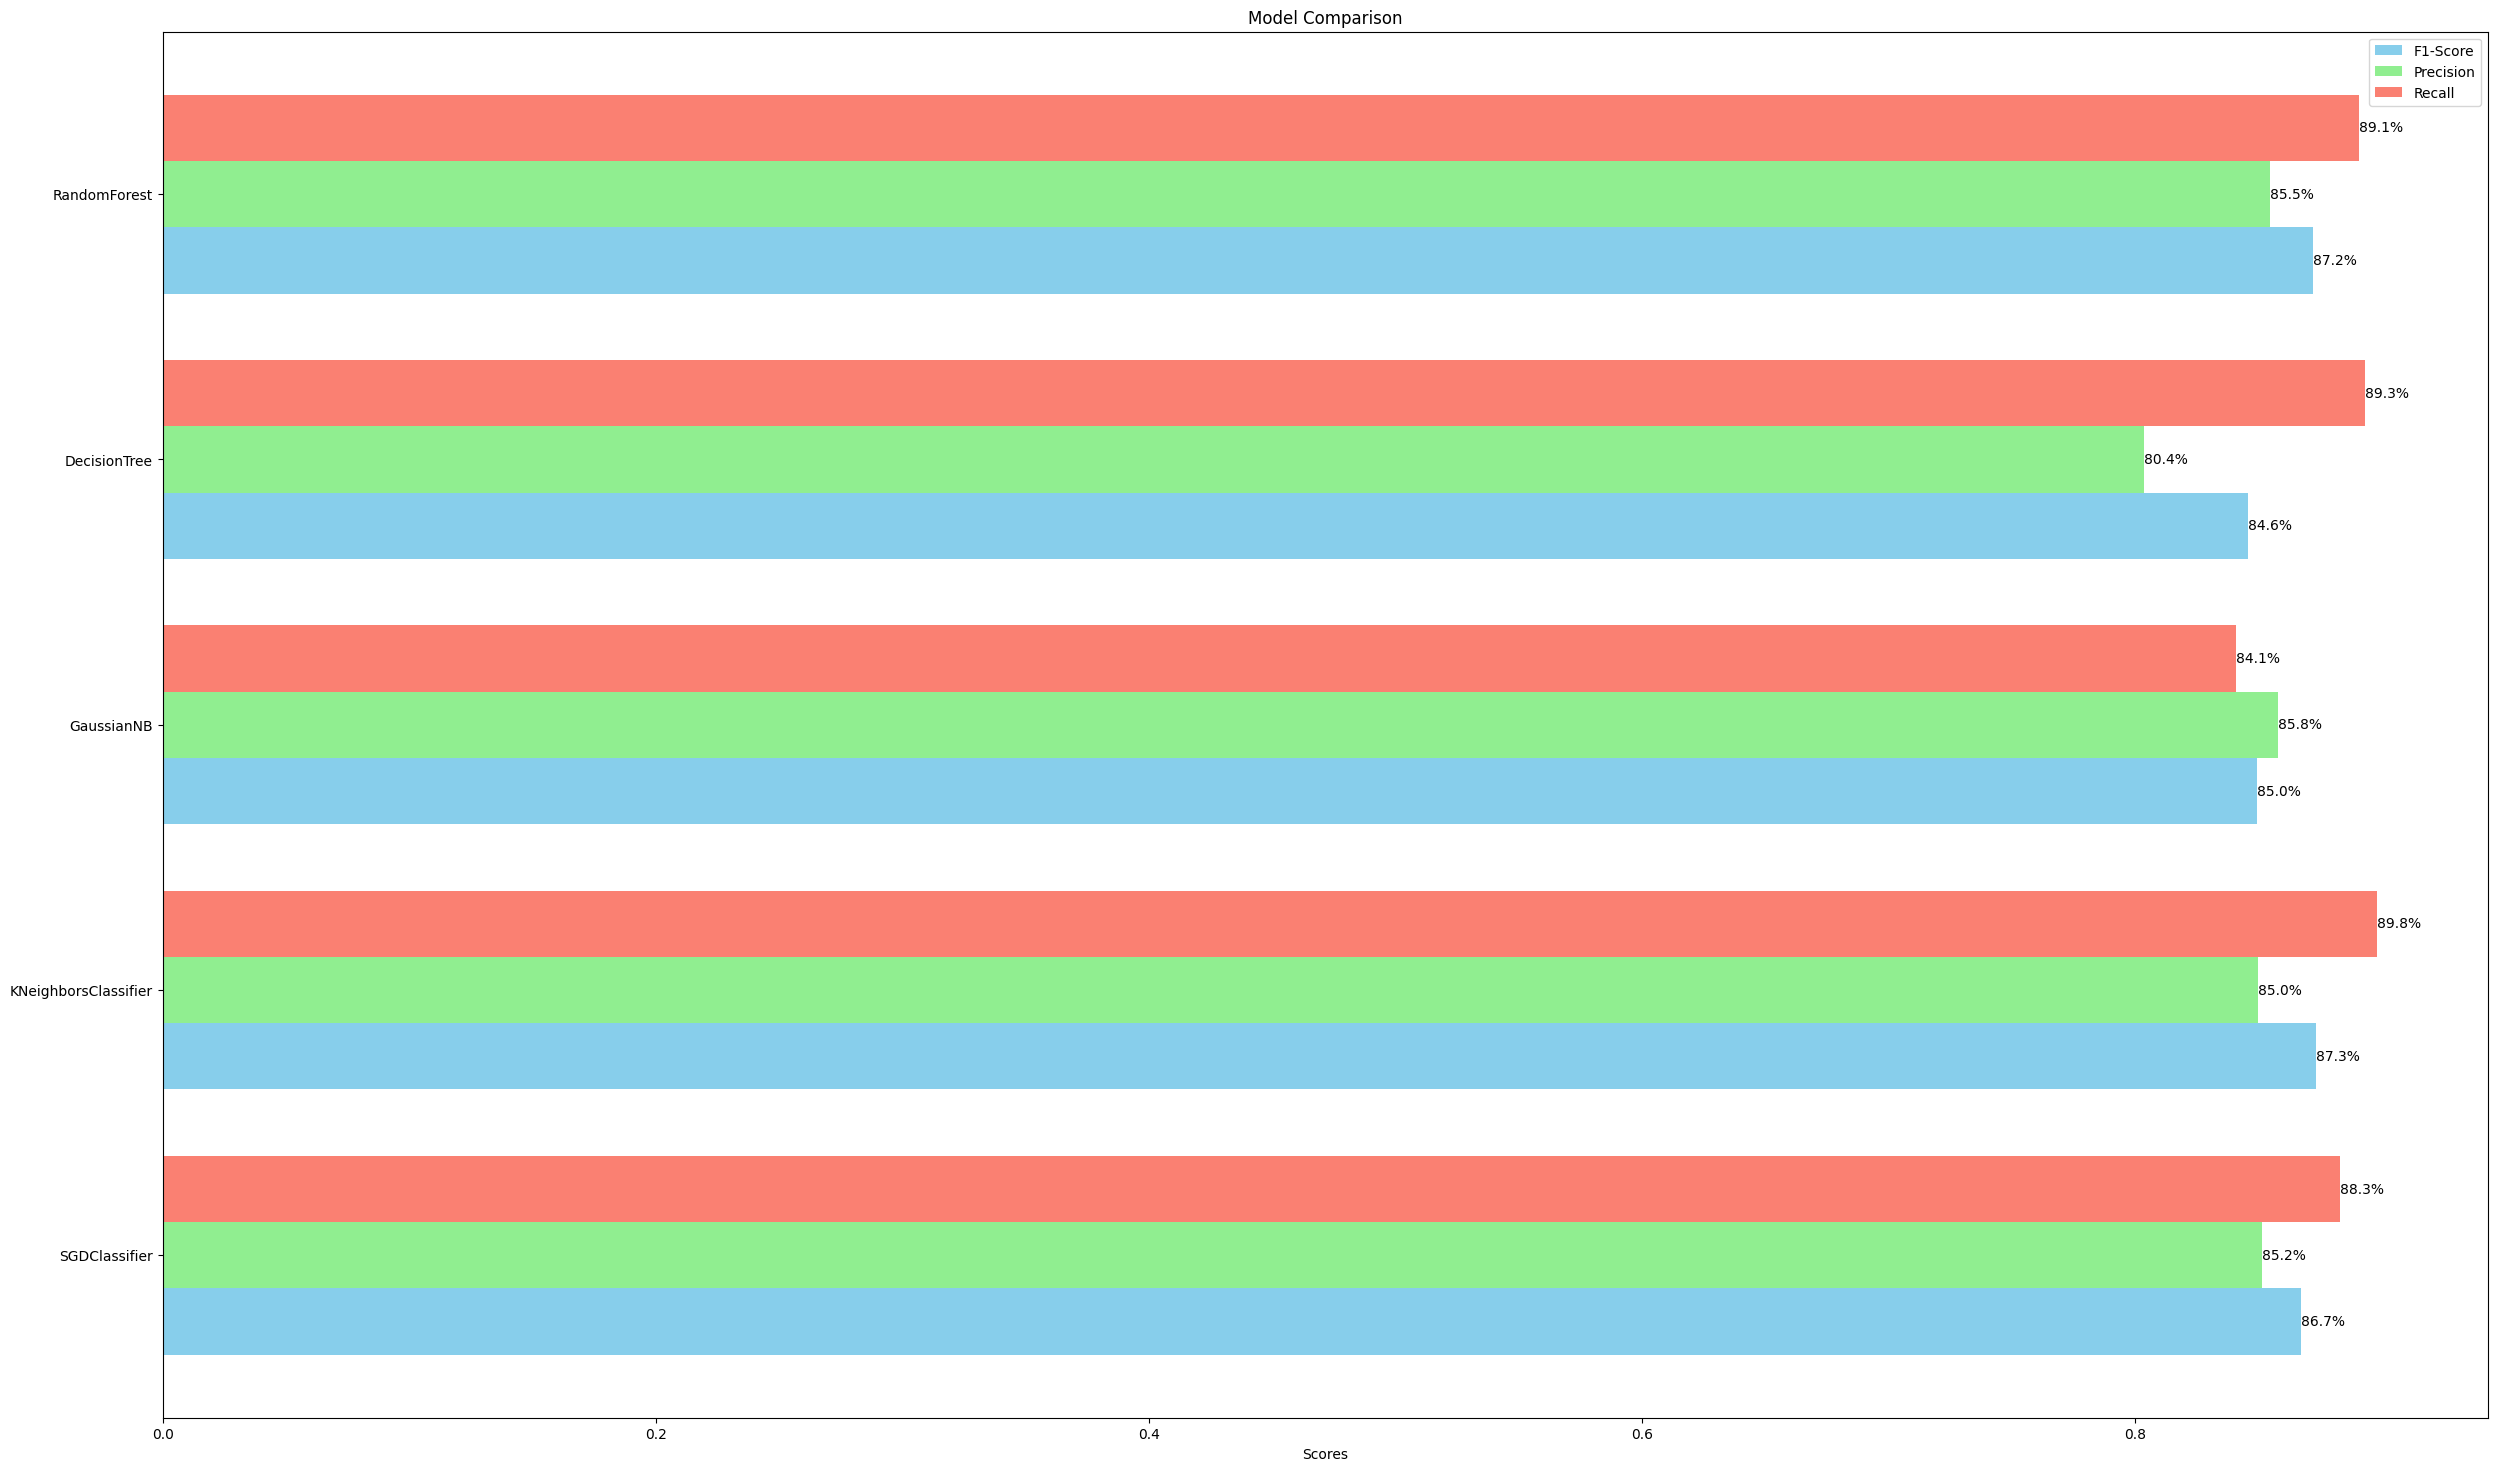

In [184]:
#Ploting scores results to compare all models
models = ['SGDClassifier','KNeighborsClassifier','GaussianNB', 'DecisionTree', 'RandomForest']
f1_scores = [sgd_clf_f1,knn_clf_f1,GaussianNB_clf_f1, dt_clf_f1, rnd_clf_f1]
precision_scores = [sgd_clf_precision,knn_clf_precision, GaussianNB_clf_precision,dt_clf_precision, rnd_clf_precision]
recall_scores = [sgd_clf_recall,knn_clf_recall,GaussianNB_clf_recall, dt_clf_recall, rnd_clf_recall]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(30, 18))
bar_width = 0.25
x = np.arange(len(models))

# Plot F1-scores, precision, and recall
ax.barh(x - bar_width, f1_scores, bar_width, label='F1-Score', color='skyblue')
ax.barh(x, precision_scores, bar_width, label='Precision', color='lightgreen')
ax.barh(x + bar_width, recall_scores, bar_width, label='Recall', color='salmon')

ax.set_yticks(x)    
ax.set_yticklabels(models)
ax.set_xlabel('Scores')
ax.set_title('Model Comparison')
ax.legend()

# Add percentage labels to each bar
for i, (f1, precision, recall) in enumerate(zip(f1_scores, precision_scores, recall_scores)):
    ax.text(f1, i - bar_width, f'{f1 * 100:.1f}%',va='center',ha='left',fontsize=10)
    ax.text(precision, i, f'{precision * 100:.1f}%',va='center',ha='left',fontsize=10)
    ax.text(recall, i + bar_width, f'{recall * 100:.1f}%',va='center',ha='left',fontsize=10)
plt.show()

From above results **rnd_clf** and **KneighborsClassifier** has the best results so I validate them both on test data

In [186]:
rnd_clf.fit(X_train,y_train)
knn_clf.fit(X_train,y_train)

rnd_test_predict=rnd_clf.predict(X_test)
knn_test_predict=knn_clf.predict(X_test)

rnd_test_f1=f1_score(y_test,rnd_test_predict)
knn_test_f1=f1_score(y_test,knn_test_predict)

print(f'rnd_clf f1 score on test data: {np.round(rnd_test_f1*100,3)}')
print(f'knn_clf f1 score on test data: {np.round(knn_test_f1*100,3)}')

rnd_clf f1 score on test data: 86.538
knn_clf f1 score on test data: 88.038


So as we see the best model is **knn_clf**